In [1]:
import tensorflow as tf
import utility.initialize_tf
from custom_models.gamornet_keras_module import *
from utility.data_loading import *
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from utility.display_prediction_results import *
from utility.data_preprocessing import *

2.5.0
2.5.0


In [2]:
training_data = "califa_s_1.0"
trained_model_path = f'saved_models\\result_models\\final\\gamornet\\sim_with_gaussian_noise'
augmented_model_path = f'saved_models\\result_models\\final\\gamornet\\augmented\\gamornet_augmented_reg'


#trained_model_path = f"./saved_models/gamornet/trained_model_califa_aug.hdf5"

In [3]:
x_dataset, y_dataset, metadata = utility.data_loading.load_hdf5_data(name=training_data)
x_dataset = np.expand_dims(x_dataset, axis=3)
y_dataset = np.expand_dims(y_dataset, axis=1)
input_shape = x_dataset.shape[1:]
print(input_shape)
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.5, random_state=2021)
print(sss.get_n_splits(x_dataset, y_dataset))


(79, 100, 100)
(100, 100, 1)
3


E:\Anaconda3\envs\hon-tf-2.5.0\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is a Python keyword: 'class'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [4]:
from tensorflow.keras.callbacks import EarlyStopping

class ReturnBestEarlyStopping(EarlyStopping):
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)


In [1]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=200, restore_best_weights=True)
return_early_stopping_callback = ReturnBestEarlyStopping(monitor='val_sparse_categorical_accuracy', patience=4900, restore_best_weights=True, verbose=1)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', patience=10)
for i, (train_index, val_index) in enumerate(sss.split(x_dataset, y_dataset)):
    train_datagen = create_datagen(x_dataset[train_index])
    val_datagen = create_datagen(x_dataset[val_index])

    trained_model, train_history = gamornet_train_keras_with_datagen(train_datagen, x_dataset[train_index], y_dataset[train_index], 
    val_datagen, x_dataset[val_index], y_dataset[val_index], input_shape=input_shape, epochs=5000, callbacks=[return_early_stopping_callback], batch_size=256, lr=0.0005, decay=0.001)#, nesterov=True, decay=0.0001) #300
    plot_learning_curve(train_history)
    plot_testing_results(trained_model.predict(x_dataset[val_index]).argmax(axis=1), y_dataset[val_index])

    trained_model.save(f"{augmented_model_path}_skf={i}.hdf5", overwrite=True)
    #break

NameError: name 'tf' is not defined

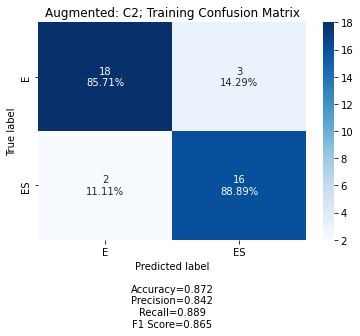

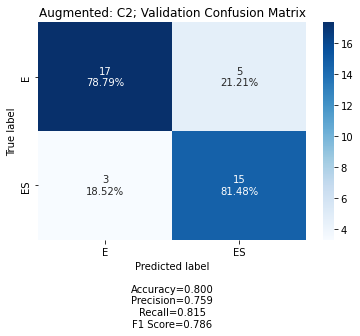

In [ ]:
training_results = []
validation_results = []
for i, (train_index, val_index) in enumerate(sss.split(x_dataset, y_dataset)):
    model = tf.keras.models.load_model(f"{augmented_model_path}_skf={i}.hdf5", custom_objects={"LocalResponseNormalization": LocalResponseNormalization})
    #plot_model_results(tuned_model, x_dataset[train_index], y_dataset[train_index], x_dataset[val_index], y_dataset[val_index], x_dataset, y_dataset)
    training_results.append(get_results(model, x_dataset[train_index], y_dataset[train_index]))
    validation_results.append(get_results(model, x_dataset[val_index], y_dataset[val_index]))
average_and_plot_results(training_results, title="Augmented: C2; Training Confusion Matrix")
average_and_plot_results(validation_results, title="Augmented: C2; Validation Confusion Matrix")


Accuracy:  0.825
Precision:  0.8235294117647058
Recall:  0.7777777777777778
F1 Score:  0.7999999999999999
Accuracy:  0.825
Precision:  0.7391304347826086
Recall:  0.9444444444444444
F1 Score:  0.8292682926829269
Accuracy:  0.75
Precision:  0.7222222222222222
Recall:  0.7222222222222222
F1 Score:  0.7222222222222222


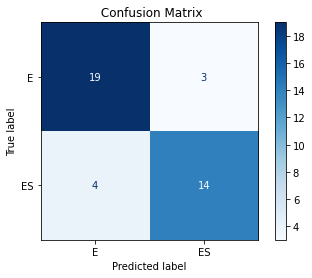

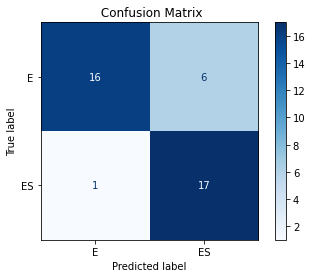

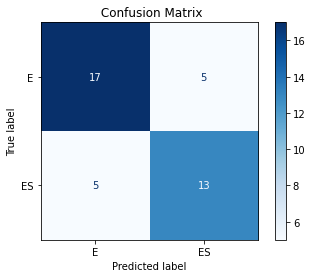

In [ ]:
for i, (train_index, val_index) in enumerate(sss.split(x_dataset, y_dataset)):
    model = tf.keras.models.load_model(f"{augmented_model_path}_skf={i}.hdf5", custom_objects={"LocalResponseNormalization": LocalResponseNormalization})
    plot_testing_results(model.predict(x_dataset[val_index]).argmax(axis=1), y_dataset[val_index])